Epoch 1/20
5/5 [==============================] - 2s 55ms/step - loss: 0.0103 - mse: 0.0233 - val_loss: 0.0129 - val_mse: 0.0300
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0227 - val_loss: 0.0128 - val_mse: 0.0297
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0096 - mse: 0.0218 - val_loss: 0.0126 - val_mse: 0.0294
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0090 - mse: 0.0203 - val_loss: 0.0126 - val_mse: 0.0294
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0082 - mse: 0.0187 - val_loss: 0.0121 - val_mse: 0.0282
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0074 - mse: 0.0168 - val_loss: 0.0116 - val_mse: 0.0270
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0067 - mse: 0.0151 - val_loss: 0.0111 - val_mse: 0.0259
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0061 - mse: 0.0137 - val

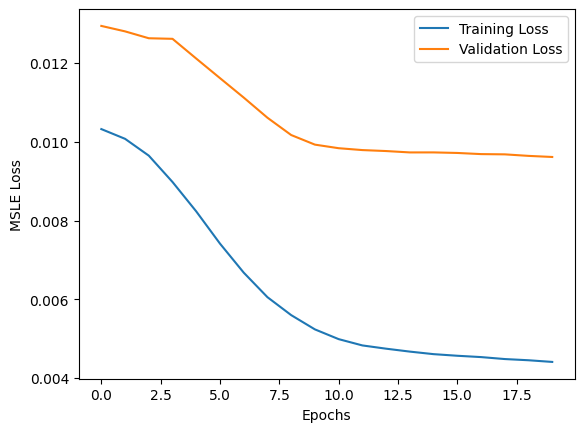

32/32 [==============================] - 0s 2ms/step


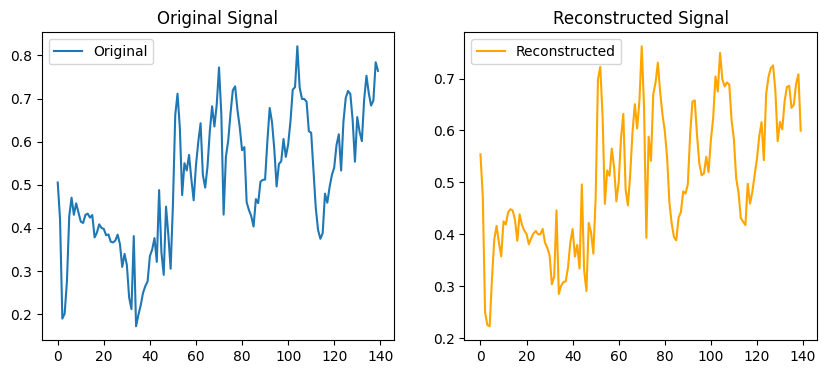

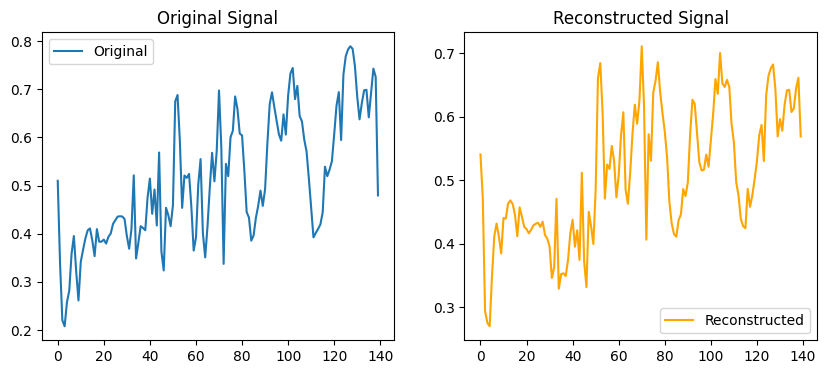

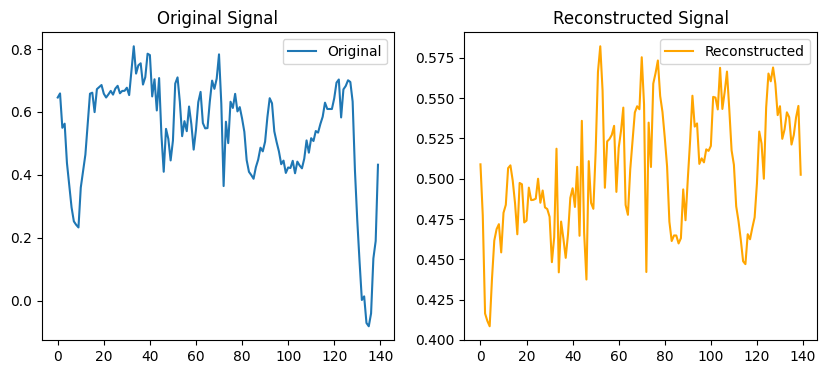

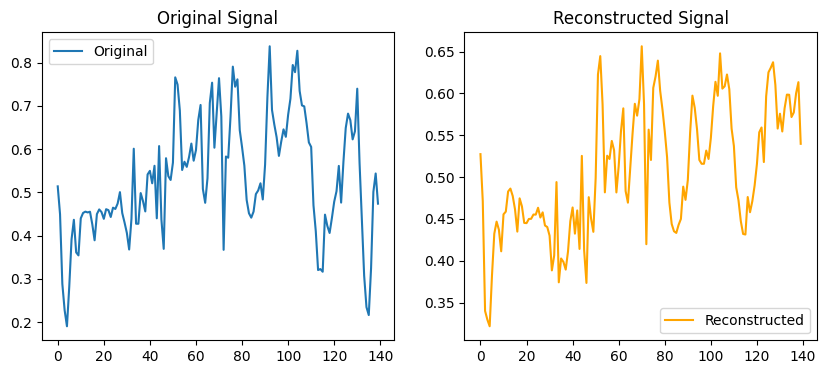

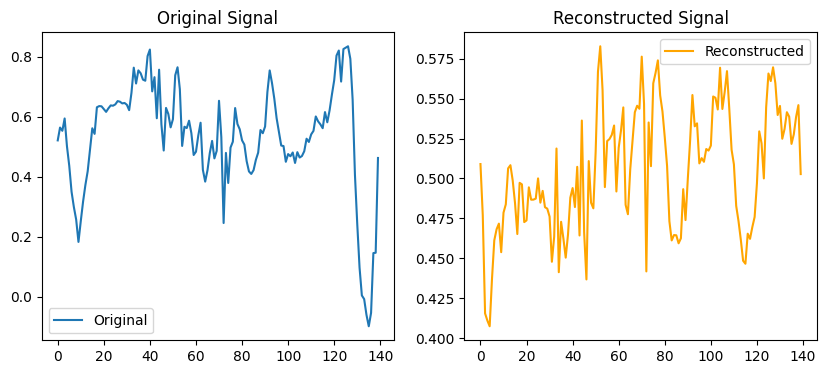

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)

# last column is the target (0 = anomaly, 1 = normal)
TARGET = 140
features = data.drop(TARGET, axis=1)
target = data[TARGET]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)

# use case is novelty detection, so use only the normal data for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

# min-max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    def __init__(self, output_units, code_size=8):
        super().__init__()
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

model = AutoEncoder(output_units=x_train_scaled.shape[1])

# configurations of the model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend()
plt.show()

# Reconstruction on test data
decoded_data = model.predict(x_test_scaled)

# Visualize the original and reconstructed signals (for the first few samples)
num_samples_to_visualize = 5
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x_test_scaled[i], label='Original')
    plt.title('Original Signal')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(decoded_data[i], label='Reconstructed', color='orange')
    plt.title('Reconstructed Signal')
    plt.legend()

    plt.show()
